In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional, Tuple

In [108]:
def vjacobi(
    fn: Callable,
    x: np.ndarray,
    p: np.ndarray,
    dp: Optional[np.ndarray] = None,
    *,
    rtol: float = 0.0,
    debug: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the Jacobi matrix of a vector-valued function.
    """

    assert p.ndim == 1
    y = fn(x, p)
    npts = len(x)

    if dp is None:
        # dp = sqrt(eps) * p optimal for forward/backward difference
        # https://en.wikipedia.org/wiki/Numerical_differentiation#Step_size
        sqrt_eps = np.sqrt(np.finfo(y.dtype).resolution)
        dp = np.where(p == 0, sqrt_eps, np.abs(p) * sqrt_eps)
    else:
        assert dp.ndim == 1
        assert np.all(dp >= 0)
    assert rtol >= 0

    y_shape = np.shape(y)
    jac = np.empty((*y_shape, len(p)))
    h = np.zeros(len(p))

    for i, dpi in enumerate(dp):
        if i > 0:
            h[i - 1] = 0

        # skip this variable if dp[i] is zero
        if dpi == 0:
            jac[:, i] = 0
            continue

        converged = np.zeros(y_shape, dtype=bool)
        prev_esq = np.full(y_shape, np.inf)

        # try to converge by making step size smaller
        h[i] = dpi
        for iter in range(20):
            assert h[i] > 0

            todo = ~converged

            # compute central derivative,
            # computing dx like this improves precision, see
            # https://en.wikipedia.org/wiki/Numerical_differentiation#Step_size
            pp = p + h
            pm = p - h
            x_todo = x[todo]
            y_todo = y[todo]
            yp = fn(x_todo, pp)
            ym = fn(x_todo, pm)
            npts += 2 * np.sum(todo)
            dp = (yp - y_todo) / (pp[i] - p[i])
            dm = (ym - y_todo) / (pm[i] - p[i])
            d = 0.5 * (dp + dm)
            derr = np.abs(dp - dm)
            if iter > 0:
                derr = np.maximum(np.abs(d - jac[todo, i]), derr)

            if rtol > 0:
                newly_converged = ~converged
                below_tolerance = (derr <= rtol * np.abs(d))
                newly_converged[todo] = below_tolerance
                if np.any(newly_converged):
                    jac[newly_converged, i] = d[below_tolerance]
                    converged |= newly_converged

                # early stop when everything is below tolerance
                if np.all(converged):
                    break

            # check for convergence of stepping algorithm
            esq = derr * derr
            todo_converging = esq < prev_esq[todo]

            # points have converged, which were previously converging
            # and are now diverging
            converged[todo] |= ~todo_converging

            if iter == 0:
                # points are divergent which "converged" on first iteration
                bad = converged
                if np.any(bad):
                    if debug:
                        print(
                            f"jacobi: ipar={i} divergence detected "
                            f"in {np.sum(bad)} points"
                        )
                    jac[bad, i] = np.nan

            converging = ~converged
            if np.any(converging):
                jac[converging, i] = d[todo_converging]

            if debug > 0:
                print(
                    f"jacobi: ipar={i} iter={iter} h={h[i]:.3e} "
                    f"{np.sum(converged)} of {np.prod(converged.shape)} converged")
                if debug > 1:
                    print(
                        f"d={d}\n"
                        f"derr={derr}\n"
                        f"rtol * abs(d)={rtol * np.abs(d)}"
                    )

            if np.all(converged):
                break

            prev_esq[todo] = esq
            h[i] *= 0.1
    
    if debug > 0:
        print(f"jacobi: {npts} points processed")
    return y, jac


jacobi: ipar=0 divergence detected in 1 points
jacobi: ipar=0 iter=0 h=3.162e-08 1 of 201 converged
jacobi: ipar=0 iter=1 h=3.162e-09 169 of 201 converged
jacobi: ipar=0 iter=2 h=3.162e-10 201 of 201 converged
jacobi: 1067 points processed


<ipython-input-111-21b39595cc16>:5: RuntimeWarning: invalid value encountered in true_divide
  return np.sin(y)/y


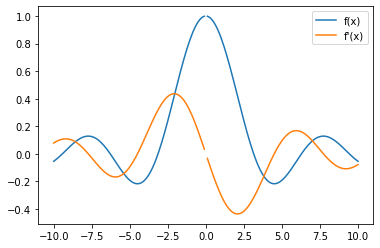

In [111]:
x = np.linspace(-10, 10, 201)

def f(x, p):
  y = np.abs(x + p)
  return np.sin(y)/y

p = np.array([0.0])
# fx, fpx = vjacobi(f, x, p, dp=np.array([1e-9]), rtol=0, debug=1)
fx, fpx = vjacobi(f, x, p, rtol=0, debug=1)

plt.plot(x, fx, label="f(x)")
plt.plot(x, fpx, label="f'(x)")
# plt.ylim(-10, 10)
plt.legend();